# Homework Assignment 8

**Question 1:** Select a book or a movie's subtitle, and find the locations that appear in the book/movie. Then, draw these locations on a map (at least 20 locations) (30pt). Connect the discovered locations with lines according to their order of appearance
in the book. For example, if location B appeared immediately after location A, then draw a line connecting locations A and B (20pt).

2023-05-30 12:45:36.730602: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 12:45:38.847240: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 747.2 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/p

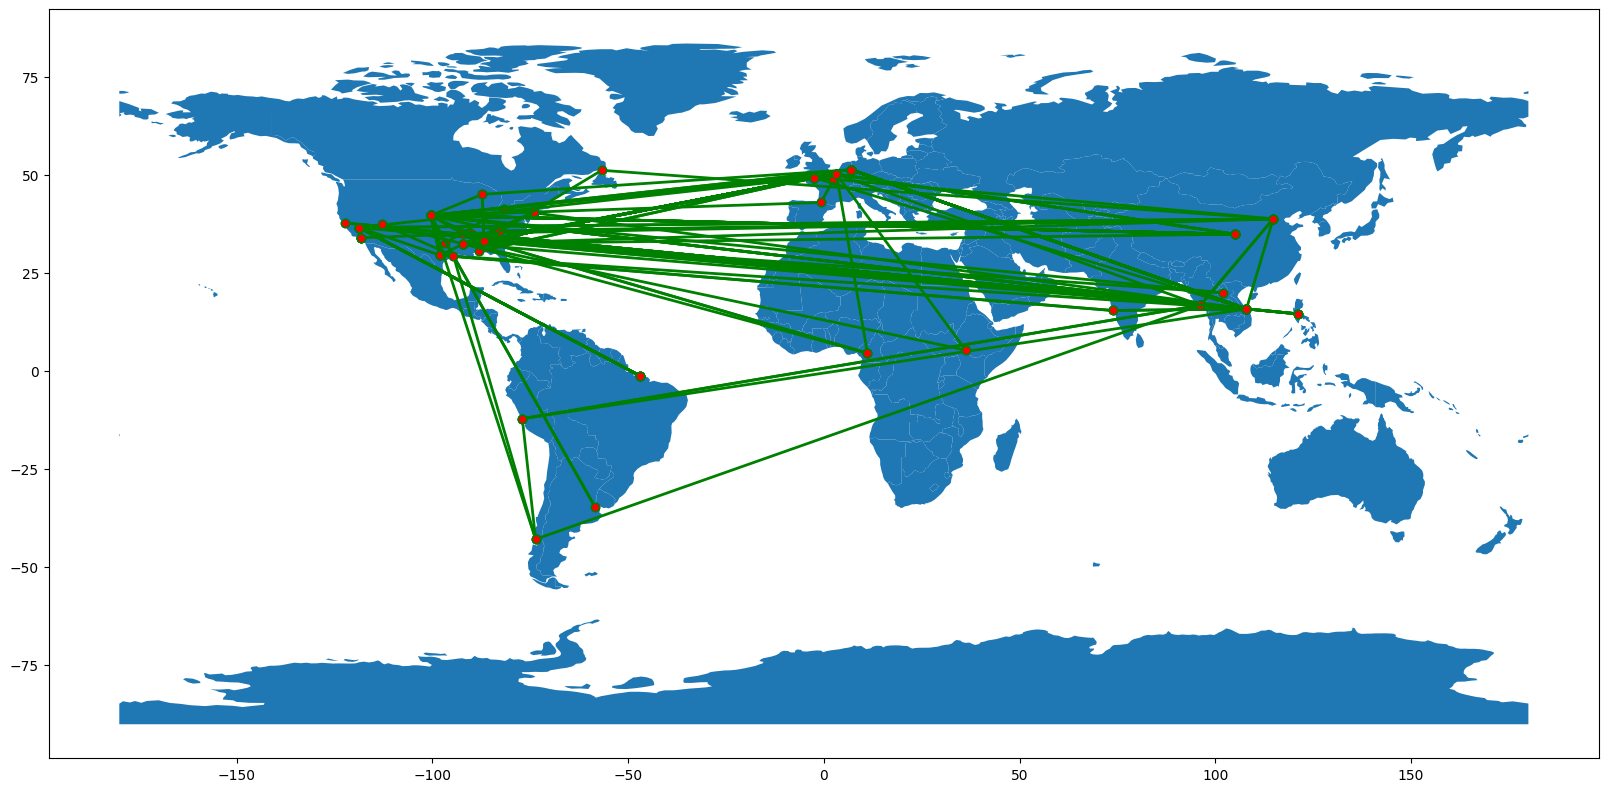

In [1]:
!python -m spacy download en_core_web_lg 
!pip install geopy
!pip install geopandas
!pip install folium


import os
import re
import json
import spacy
import geopandas
import itertools
import math
import warnings
import folium
import pandas as pd
import networkx as nx
import plotly.express as px
from matplotlib import pyplot as plt
from geopy.geocoders import Nominatim
warnings.filterwarnings('ignore')


# Config kaggle
!mkdir /root/.kaggle/
api_token = {"username":"","key":""}
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
# Download data
!kaggle datasets download -d adiamaan/movie-subtitle-dataset
# Unzip data
!unzip -o movie-subtitle-dataset.zip
# Get 1 subtitle
movies_subtitles_df = pd.read_csv("movies_subtitles.csv", encoding='utf8')
subtitle = movies_subtitles_df[movies_subtitles_df.imdb_id== "tt0109830"].sort_values("start_time")
# load spacy
nlp = spacy.load('en_core_web_lg')
# Method to get locations from text
def get_locations_from_text(text):
    loc_dict= {}
    doc = nlp(text)
    for entity in doc.ents:
        if entity.label_ in {'GPE'}:
            loc = entity.text.lower().strip()
            loc_dict[loc] = loc_dict.get(loc, 0) + 1
    return loc_dict
# Get locations for subtitle
locations_dict = get_locations_from_text(subtitle.text.str.cat())
locations = sorted(locations_dict.items(), key=lambda item: item[1], reverse=True)
# Get real locations of each location entity found
geolocator = Nominatim(user_agent="Data Science Education App")
real_locations= []
for loc, appearance in locations:
  try:
    real_location = geolocator.geocode(loc)
    real_locations.append(dict(location=loc, appearance=appearance, latitude=real_location.latitude,longitude=real_location.longitude, address=real_location.address))
  except:
    continue 
# Get locations according to their order of appearance
loc_order = []
subtitle_text = subtitle.text.str.cat().lower()
for i in real_locations:
    loc_order += [(i, j.start(0)) for j in re.finditer(i["location"], subtitle_text)]
loc_order = sorted(loc_order, key=lambda x: x[1])
loc_order = [k for k,g in itertools.groupby(loc_order, lambda x: x[0])]
# Draw locations and thier connections
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(20,20))
for idx in range(len(loc_order)-1):
    loc = loc_order[idx]
    loc_next = loc_order[idx+1]
    plt.plot([loc["longitude"],loc_next["longitude"]], [loc["latitude"],loc_next["latitude"]], c='green', mfc='red' , linewidth=2, marker='o')
plt.show()

**Question 2:** Select a country's' statistic from the [World Development Indicators dataset](https://www.kaggle.com/datasets/kaggle/world-development-indicators) (Please notice there are several files in the dataset, such as _Indicators.csv_).
Then, create a choropleth map displaying how the selected statistics changed over time (15pt) 
    
**Bonus:** Create a short animation that displays how the chosen statistics changed over time (15pt)

In [2]:
# Download data
!kaggle datasets download -d kaggle/world-development-indicators
# Unzip data
!unzip -o world-development-indicators.zip
# Choropleth map displaying how the selected statistics changed over time
indicators_df = pd.read_csv("Indicators.csv", encoding="utf8")
indicator_name = "Birth rate, crude (per 1,000 people)"
filter_indicators_df = indicators_df[indicators_df.IndicatorName == indicator_name]
filter_indicators_df = filter_indicators_df[~filter_indicators_df.CountryCode.isin(['CHN', 'IND'])]
fig = px.choropleth(filter_indicators_df, locations="CountryCode",locationmode="ISO-3", 
              color="Value",  animation_frame="Year", width=800, height=400)
fig.update_layout(title_text=f"Global  {indicator_name} from {filter_indicators_df.Year.min()} to {filter_indicators_df.Year.max()}", title_x=0.5)

 98% 361M/369M [00:03<00:00, 143MB/s]
100% 369M/369M [00:03<00:00, 127MB/s]
Archive:  world-development-indicators.zip
  inflating: Country.csv             
  inflating: CountryNotes.csv        
  inflating: Footnotes.csv           
  inflating: Indicators.csv          
  inflating: Series.csv              
  inflating: SeriesNotes.csv         
  inflating: database.sqlite         
  inflating: hashes.txt              


**Question 3:** Use data from [the Meteorite Landings dataset](https://www.kaggle.com/datasets/nasa/meteorite-landings).
Create maps that present where the Meteorites landed and their mass. Additionally, draw choropleth map that give information how many different meteorites landed in each country and how it changes over the years (35pt).

In [3]:
# Download data
!kaggle datasets download -d nasa/meteorite-landings
# Unzip data
!unzip -o meteorite-landings.zip
# Read data
meteorite_df = pd.read_csv("meteorite-landings.csv", encoding='utf8')
# remove nan mass & year & GeoLocation
meteorite_df=meteorite_df[~meteorite_df.mass.isna()]
meteorite_df=meteorite_df[~meteorite_df.year.isna()]
meteorite_df=meteorite_df[~meteorite_df.GeoLocation.isna()]
# Create map that present where the Meteorites landed and their mass
tiles = 'Stamen Terrain'
m = folium.Map(location=[0,0], zoom_start=2,
               tiles = tiles)
for idx, r in meteorite_df.sample(5000).iterrows():
    tooltip = f"Mass: {r['mass']}\n Location ({(r['reclat'],r['reclong'])})" 
    folium.Marker(
        location=[r['reclat'],r['reclong']],
        popup= tooltip,
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

meteorite-landings.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  meteorite-landings.zip
  inflating: meteorite-landings.csv  


In [4]:
m

In [5]:
# Draw choropleth map that give information how many different meteorites landed in each country and how it changes over the years
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
gdf = geopandas.GeoDataFrame(meteorite_df, geometry=geopandas.points_from_xy(meteorite_df.reclong, meteorite_df.reclat))
result = geopandas.sjoin(gdf, world, how='left')
group_meteorite_df = result.groupby(["iso_a3","year"]).count().reset_index().sort_values("year")
fig = px.choropleth(group_meteorite_df, locations="iso_a3",locationmode="ISO-3", 
              color="mass", animation_frame="year", width=1000, height=800)
fig.update_layout(title_text=f"Global  meteorites landed from {group_meteorite_df.year.min()} to {group_meteorite_df.year.max()}", title_x=0.5)